In [5]:
# Utilities
import numpy as np
import pandas as pd

# ML
#import sklearn
#sklearn.__version__# use this when reopening previously saved ML models
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error, mean_absolute_error
    #pprint allows us to see current hyperparameter values of our model 
from pprint import pprint
# import data
fullData = pd.read_csv("vminStd.csv")
permanent = pd.read_csv("vminStd.csv")
fullData.head()

,File Index,Chip Type,Chip Temp,Test Number,Test Item,Library #1,Library #2,Library #3,VDD (Range),DVDD (Range),Period (Range),Result,Shmoo Value
0,101,TT,25,600,sc7p5mcpp96p,sfk,lvt,c16,0.495 V,0.900 V,100.00 ns,(P),NaN
1,101,TT,25,601,sc7p5mcpp96p,sfk,lvt,c18,0.495 V,0.900 V,100.00 ns,(P),NaN
2,101,TT,25,602,sc7p5mcpp96p,sfk,lvt,c20,0.495 V,0.900 V,100.00 ns,(P),NaN
3,101,TT,25,603,sc7p5mcpp96p,sfk,lvt,c24,0.495 V,0.900 V,100.00 ns,(P),NaN
4,101,TT,25,604,sc7p5mcpp96p,sfk,svt,c16,0.495 V,0.900 V,100.00 ns,(P),NaN


In [4]:
# only keep rows with Vmin value, and delete unuseful columns
fullData.dropna(subset=['Shmoo Value'], inplace=True)
fullData.drop(["VDD (Range)", "Library #1", "DVDD (Range)", "Period (Range)", "Result", "Test Number"], axis = 1, inplace = True)
##########################################################################################
# DROP FILE INDEX COLUMN FOR NOW, ADD THE DATA LATER TO INCLUDE LEAKAGE ETC IN THE MODEL.
fullData.drop(["File Index"], axis = 1, inplace = True)
##########################################################################################

# Change strings to integers, get rid of 'V' for voltages, etc...
fullData['Shmoo Value'] = fullData['Shmoo Value'].map(lambda x: x.rstrip('V'))
fullData["Shmoo Value"] = fullData["Shmoo Value"].astype('float')

# Use this to decide between one-hot encoding and categorical encoding (or else)
'''print("Data Columns and Different Values: ")
print(fullData.columns)
print()
for column in fullData.columns:
    print(fullData[str(column)].unique())
'''
# one hot encode categorical values. See bookmarks for why one hot rather than else
fullData = pd.get_dummies(fullData, columns=["Chip Type", "Library #2"])

fullData["Test Item"] = fullData["Test Item"].astype('category')
fullData["Test Item"] = fullData["Test Item"].cat.codes
fullData["Library #3"] = fullData["Library #3"].astype('category')
fullData["Library #3"] = fullData["Library #3"].cat.codes

###################### Continuous normalized temp#######################################################
fullData['Chip Temp'] = pd.to_numeric(fullData['Chip Temp'], errors='coerce').fillna(-40.0).astype(float)
fullData['Chip Temp'] = fullData['Chip Temp'].map(lambda x: x/150.0)

# create training and testing sets
X = fullData.copy()
X = shuffle(X)
y = X["Shmoo Value"]
X.drop(["Shmoo Value"], axis = 1, inplace = True)

X_train = X[:8196]
y_train = y[:8196]
X_test = X[-1500:]
y_test = y[-1500:]

In [22]:
print(X_train.head())

       Chip Temp  Test Item  Library #3  Chip Type_FF  Chip Type_FS  \
17756   0.166667          1           0             0             0   
2634    1.000000          1           2             0             0   
36227   1.000000          0           3             1             0   
54953  -0.266667          1           1             0             1   
67913   0.166667          1           1             0             0   

       Chip Type_SF  Chip Type_SS  Chip Type_TT  Library #2_lvt  \
17756             0             0             1               0   
2634              0             0             1               0   
36227             0             0             0               0   
54953             0             0             0               0   
67913             1             0             0               0   

       Library #2_svt  Library #2_ulvt  
17756               0                1  
2634                1                0  
36227               0                1  
54953 

In [6]:
rf = linear_model.SGDRegressor()
pprint(rf.get_params())


random_grid = {
    'alpha': 10.0 ** -np.arange(1, 7),
    'loss': ['squared_loss', 'huber', 'epsilon_insensitive'],
    'penalty': ['l2', 'l1', 'elasticnet'],
    'learning_rate': ['constant', 'optimal', 'invscaling'],
}
pprint(random_grid)


rf = linear_model.SGDRegressor(random_state=42)
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=50, random_state=42)

rf_random.fit(X_train, y_train)
rf_random.best_params_


{'alpha': 0.0001,
 'average': False,
 'early_stopping': False,
 'epsilon': 0.1,
 'eta0': 0.01,
 'fit_intercept': True,
 'l1_ratio': 0.15,
 'learning_rate': 'invscaling',
 'loss': 'squared_loss',
 'max_iter': 1000,
 'n_iter_no_change': 5,
 'penalty': 'l2',
 'power_t': 0.25,
 'random_state': None,
 'shuffle': True,
 'tol': 0.001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}
{'alpha': array([1.e-01, 1.e-02, 1.e-03, 1.e-04, 1.e-05, 1.e-06]),
 'learning_rate': ['constant', 'optimal', 'invscaling'],
 'loss': ['squared_loss', 'huber', 'epsilon_insensitive'],
 'penalty': ['l2', 'l1', 'elasticnet']}
Fitting 3 folds for each of 100 candidates, totalling 300 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] penalty=elasticnet, loss=huber, learning_rate=invscaling, alpha=1e-06 
[CV]  penalty=elasticnet, loss=huber, learning_rate=invscaling, alpha=1e-06, score=0.931, total=   0.1s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0

[CV]  penalty=l2, loss=squared_loss, learning_rate=optimal, alpha=1e-06, score=-1237418333678829815178723328.000, total=   0.3s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    1.9s remaining:    0.0s
[CV] penalty=l1, loss=squared_loss, learning_rate=invscaling, alpha=0.1 
[CV]  penalty=l1, loss=squared_loss, learning_rate=invscaling, alpha=0.1, score=-0.000, total=   0.0s
[Parallel(n_jobs=1)]: Done  31 out of  31 | elapsed:    1.9s remaining:    0.0s
[CV] penalty=l1, loss=squared_loss, learning_rate=invscaling, alpha=0.1 
[CV]  penalty=l1, loss=squared_loss, learning_rate=invscaling, alpha=0.1, score=-0.000, total=   0.0s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    1.9s remaining:    0.0s
[CV] penalty=l1, loss=squared_loss, learning_rate=invscaling, alpha=0.1 
[CV]  penalty=l1, loss=squared_loss, learning_rate=invscaling, alpha=0.1, score=-0.002, total=   0.0s
[Parallel(n_jobs=1)]: Done  33 out of  33 | elapsed:    2.0s remaining:    0.0s
[CV] penalty=l2, loss=huber

[CV]  penalty=l2, loss=squared_loss, learning_rate=optimal, alpha=0.1, score=-116.812, total=   0.2s
[CV] penalty=l2, loss=squared_loss, learning_rate=optimal, alpha=0.1 .


/home/sv116/my_project_dir/my_project_env/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:1185: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


[CV]  penalty=l2, loss=squared_loss, learning_rate=optimal, alpha=0.1, score=-3429.009, total=   0.6s
[CV] penalty=l2, loss=squared_loss, learning_rate=optimal, alpha=0.1 .


/home/sv116/my_project_dir/my_project_env/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:1185: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


[CV]  penalty=l2, loss=squared_loss, learning_rate=optimal, alpha=0.1, score=-390924.075, total=   0.7s
[CV] penalty=l1, loss=huber, learning_rate=constant, alpha=0.01 ......
[CV]  penalty=l1, loss=huber, learning_rate=constant, alpha=0.01, score=0.519, total=   0.0s
[CV] penalty=l1, loss=huber, learning_rate=constant, alpha=0.01 ......
[CV]  penalty=l1, loss=huber, learning_rate=constant, alpha=0.01, score=0.529, total=   0.0s
[CV] penalty=l1, loss=huber, learning_rate=constant, alpha=0.01 ......
[CV]  penalty=l1, loss=huber, learning_rate=constant, alpha=0.01, score=0.483, total=   0.0s
[CV] penalty=l2, loss=squared_loss, learning_rate=invscaling, alpha=1e-06 
[CV]  penalty=l2, loss=squared_loss, learning_rate=invscaling, alpha=1e-06, score=0.931, total=   0.0s
[CV] penalty=l2, loss=squared_loss, learning_rate=invscaling, alpha=1e-06 
[CV]  penalty=l2, loss=squared_loss, learning_rate=invscaling, alpha=1e-06, score=0.929, total=   0.0s
[CV] penalty=l2, loss=squared_loss, learning_rat

[CV]  penalty=l2, loss=squared_loss, learning_rate=optimal, alpha=0.0001, score=-223410333555109.750, total=   0.2s
[CV] penalty=l2, loss=squared_loss, learning_rate=optimal, alpha=0.0001 
[CV]  penalty=l2, loss=squared_loss, learning_rate=optimal, alpha=0.0001, score=-5362873658202.908, total=   0.2s
[CV] penalty=l2, loss=squared_loss, learning_rate=optimal, alpha=0.0001 
[CV]  penalty=l2, loss=squared_loss, learning_rate=optimal, alpha=0.0001, score=-10216028166558.959, total=   0.2s
[CV] penalty=elasticnet, loss=epsilon_insensitive, learning_rate=invscaling, alpha=0.1 
[CV]  penalty=elasticnet, loss=epsilon_insensitive, learning_rate=invscaling, alpha=0.1, score=0.120, total=   0.0s
[CV] penalty=elasticnet, loss=epsilon_insensitive, learning_rate=invscaling, alpha=0.1 
[CV]  penalty=elasticnet, loss=epsilon_insensitive, learning_rate=invscaling, alpha=0.1, score=0.084, total=   0.0s
[CV] penalty=elasticnet, loss=epsilon_insensitive, learning_rate=invscaling, alpha=0.1 
[CV]  penalty

/home/sv116/my_project_dir/my_project_env/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:1185: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


[CV]  penalty=l2, loss=squared_loss, learning_rate=optimal, alpha=0.01, score=-144443800736863.219, total=   0.5s
[CV] penalty=l2, loss=squared_loss, learning_rate=optimal, alpha=0.01 


/home/sv116/my_project_dir/my_project_env/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:1185: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


[CV]  penalty=l2, loss=squared_loss, learning_rate=optimal, alpha=0.01, score=-4842692040467532.000, total=   0.6s
[CV] penalty=l2, loss=squared_loss, learning_rate=optimal, alpha=0.01 


/home/sv116/my_project_dir/my_project_env/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:1185: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


[CV]  penalty=l2, loss=squared_loss, learning_rate=optimal, alpha=0.01, score=-3998091422962252.500, total=   0.5s
[CV] penalty=l2, loss=squared_loss, learning_rate=constant, alpha=0.0001 
[CV]  penalty=l2, loss=squared_loss, learning_rate=constant, alpha=0.0001, score=0.928, total=   0.0s
[CV] penalty=l2, loss=squared_loss, learning_rate=constant, alpha=0.0001 
[CV]  penalty=l2, loss=squared_loss, learning_rate=constant, alpha=0.0001, score=0.927, total=   0.0s
[CV] penalty=l2, loss=squared_loss, learning_rate=constant, alpha=0.0001 
[CV]  penalty=l2, loss=squared_loss, learning_rate=constant, alpha=0.0001, score=0.926, total=   0.0s
[CV] penalty=l1, loss=huber, learning_rate=invscaling, alpha=0.1 .....
[CV]  penalty=l1, loss=huber, learning_rate=invscaling, alpha=0.1, score=-0.001, total=   0.0s
[CV] penalty=l1, loss=huber, learning_rate=invscaling, alpha=0.1 .....
[CV]  penalty=l1, loss=huber, learning_rate=invscaling, alpha=0.1, score=-0.001, total=   0.0s
[CV] penalty=l1, loss=hub

/home/sv116/my_project_dir/my_project_env/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:1185: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


[CV]  penalty=elasticnet, loss=squared_loss, learning_rate=optimal, alpha=0.1, score=-13258.807, total=   1.0s
[CV] penalty=elasticnet, loss=squared_loss, learning_rate=optimal, alpha=0.1 


/home/sv116/my_project_dir/my_project_env/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:1185: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


[CV]  penalty=elasticnet, loss=squared_loss, learning_rate=optimal, alpha=0.1, score=-1198592.467, total=   0.9s
[CV] penalty=elasticnet, loss=squared_loss, learning_rate=optimal, alpha=0.001 
[CV]  penalty=elasticnet, loss=squared_loss, learning_rate=optimal, alpha=0.001, score=-6722041770099811.000, total=   0.4s
[CV] penalty=elasticnet, loss=squared_loss, learning_rate=optimal, alpha=0.001 
[CV]  penalty=elasticnet, loss=squared_loss, learning_rate=optimal, alpha=0.001, score=-317903288270192.688, total=   0.9s
[CV] penalty=elasticnet, loss=squared_loss, learning_rate=optimal, alpha=0.001 
[CV]  penalty=elasticnet, loss=squared_loss, learning_rate=optimal, alpha=0.001, score=-5014064297024190.000, total=   0.6s
[CV] penalty=l1, loss=huber, learning_rate=constant, alpha=0.0001 ....
[CV]  penalty=l1, loss=huber, learning_rate=constant, alpha=0.0001, score=0.927, total=   0.0s
[CV] penalty=l1, loss=huber, learning_rate=constant, alpha=0.0001 ....
[CV]  penalty=l1, loss=huber, learning_

[CV]  penalty=elasticnet, loss=huber, learning_rate=optimal, alpha=0.0001, score=0.900, total=   0.0s
[CV] penalty=elasticnet, loss=huber, learning_rate=optimal, alpha=0.0001 
[CV]  penalty=elasticnet, loss=huber, learning_rate=optimal, alpha=0.0001, score=0.798, total=   0.0s
[CV] penalty=elasticnet, loss=huber, learning_rate=optimal, alpha=0.0001 
[CV]  penalty=elasticnet, loss=huber, learning_rate=optimal, alpha=0.0001, score=0.807, total=   0.0s
[CV] penalty=l2, loss=epsilon_insensitive, learning_rate=constant, alpha=1e-05 
[CV]  penalty=l2, loss=epsilon_insensitive, learning_rate=constant, alpha=1e-05, score=0.716, total=   0.0s
[CV] penalty=l2, loss=epsilon_insensitive, learning_rate=constant, alpha=1e-05 
[CV]  penalty=l2, loss=epsilon_insensitive, learning_rate=constant, alpha=1e-05, score=0.774, total=   0.0s
[CV] penalty=l2, loss=epsilon_insensitive, learning_rate=constant, alpha=1e-05 
[CV]  penalty=l2, loss=epsilon_insensitive, learning_rate=constant, alpha=1e-05, score=0.7

[CV]  penalty=l2, loss=huber, learning_rate=optimal, alpha=0.0001, score=0.897, total=   0.1s
[CV] penalty=elasticnet, loss=epsilon_insensitive, learning_rate=invscaling, alpha=1e-05 
[CV]  penalty=elasticnet, loss=epsilon_insensitive, learning_rate=invscaling, alpha=1e-05, score=0.677, total=   0.1s
[CV] penalty=elasticnet, loss=epsilon_insensitive, learning_rate=invscaling, alpha=1e-05 
[CV]  penalty=elasticnet, loss=epsilon_insensitive, learning_rate=invscaling, alpha=1e-05, score=0.519, total=   0.1s
[CV] penalty=elasticnet, loss=epsilon_insensitive, learning_rate=invscaling, alpha=1e-05 
[CV]  penalty=elasticnet, loss=epsilon_insensitive, learning_rate=invscaling, alpha=1e-05, score=0.560, total=   0.0s
[CV] penalty=l1, loss=huber, learning_rate=invscaling, alpha=1e-06 ...
[CV]  penalty=l1, loss=huber, learning_rate=invscaling, alpha=1e-06, score=0.931, total=   0.0s
[CV] penalty=l1, loss=huber, learning_rate=invscaling, alpha=1e-06 ...
[CV]  penalty=l1, loss=huber, learning_rate=

{'penalty': 'l1',
 'loss': 'squared_loss',
 'learning_rate': 'invscaling',
 'alpha': 1e-06}

In [7]:
base_model = linear_model.SGDRegressor(random_state = 42)
base_model.fit(X_train, y_train)
y_predicted_base = base_model.predict(X_test)
from sklearn.metrics import mean_absolute_error
print(mean_absolute_error(y_test, y_predicted_base))

best_random = rf_random.best_estimator_
y_predicted_random = best_random.predict(X_test)
print(mean_absolute_error(y_test, y_predicted_random))

for i in range(5):
    print("For the base model:")
    print("The test label is " + str(y_test.iloc[i]) + " and the predicted value is " + str(y_predicted_base[i]))
    print("For the randomized search optimal model:")
    print("The test label is still " + str(y_test.iloc[i]) + " and the predicted value is " + str(y_predicted_random[i]))



0.010834643627530052
0.010834610355475989
For the base model:
The test label is 0.29 and the predicted value is 0.2850391246433185
For the randomized search optimal model:
The test label is still 0.29 and the predicted value is 0.2850408131066344
For the base model:
The test label is 0.395 and the predicted value is 0.394411368687573
For the randomized search optimal model:
The test label is still 0.395 and the predicted value is 0.39444550800717776
For the base model:
The test label is 0.225 and the predicted value is 0.22176488145922602
For the randomized search optimal model:
The test label is still 0.225 and the predicted value is 0.22174459206980124
For the base model:
The test label is 0.31 and the predicted value is 0.3261234053675829
For the randomized search optimal model:
The test label is still 0.31 and the predicted value is 0.326143055376632
For the base model:
The test label is 0.325 and the predicted value is 0.3430302758450094
For the randomized search optimal model:
Th

In [8]:
'''
# forget about this
param_grid = {
    'bootstrap': [True],
    'max_depth': [10],
    'max_features': ['auto'],
    'min_samples_leaf': [5],
    'min_samples_split': [4],
    'n_estimators': [200]
}

rfGrid = RandomForestRegressor()
grid_search = GridSearchCV(estimator = rfGrid, param_grid = param_grid, 
                          cv = 6, verbose = 2)

grid_search.fit(X_train, y_train)
grid_search.best_params_
'''

"\n# forget about this\nparam_grid = {\n    'bootstrap': [True],\n    'max_depth': [10],\n    'max_features': ['auto'],\n    'min_samples_leaf': [5],\n    'min_samples_split': [4],\n    'n_estimators': [200]\n}\n\nrfGrid = RandomForestRegressor()\ngrid_search = GridSearchCV(estimator = rfGrid, param_grid = param_grid, \n                          cv = 6, verbose = 2)\n\ngrid_search.fit(X_train, y_train)\ngrid_search.best_params_\n"

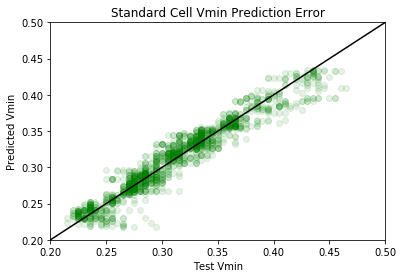

0.010834610355475989
0.03463971595203015


['SGDVminBasic.joblib']

In [12]:
plt.scatter(y_test, y_predicted_random,  color='green', alpha=0.1)
plt.xlim([0.2,0.5])
plt.ylim([0.2,0.5])
plt.plot([0.2,0.5],[0.2,0.5], color='black')
plt.xlabel("Test Vmin")
plt.ylabel("Predicted Vmin")
plt.title("Standard Cell Vmin Prediction Error")
plt.show()

print(mean_absolute_error(y_test, y_predicted_random))
print(mean_absolute_error(y_test, y_predicted_random)/y_test.mean())

from joblib import dump, load
dump(best_random, 'SGDVminBasic.joblib')